# Step-by-step demonstration

## Lib Imports and configurations

In [9]:
# %matplotlib notebook
# %matplotlib inline 
%load_ext autoreload
%autoreload 2

import sys
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
from ruptures.metrics import precision_recall, meantime
import scipy.stats as ss

sys.path.append("Codes/")

import TMPD_utils
import TMPD_class

import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 150)
# pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
pd.options.display.float_format = '{:.4f}'.format


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading event log

In [10]:
# Mapping all event_logs paths
logs_path = glob.glob("Input/Synthetic/Synthetic Event Streams (Ceravolo - Evaluation)/*")

# Removing the logs with 100 cases only events 
logs_path = [x for x in logs_path if "_baseline" not in x and "_100_" not in x and "_trace_" in x and "recurring" in x]

# Showing mapped paths
print("How many logs? ", len(logs_path))
pd.DataFrame(logs_path).head(30)

How many logs?  150


,0
0,Input/Synthetic/Synthetic Event Streams (Ceravolo - Evaluation)\recurring_trace_noise0_1000_cb.csv
1,Input/Synthetic/Synthetic Event Streams (Ceravolo - Evaluation)\recurring_trace_noise0_1000_cd.csv
2,Input/Synthetic/Synthetic Event Streams (Ceravolo - Evaluation)\recurring_trace_noise0_1000_cf.csv
3,Input/Synthetic/Synthetic Event Streams (Ceravolo - Evaluation)\recurring_trace_noise0_1000_cp.csv
4,Input/Synthetic/Synthetic Event Streams (Ceravolo - Evaluation)\recurring_trace_noise0_1000_IOR.csv
5,Input/Synthetic/Synthetic Event Streams (Ceravolo - Evaluation)\recurring_trace_noise0_1000_IRO.csv
6,Input/Synthetic/Synthetic Event Streams (Ceravolo - Evaluation)\recurring_trace_noise0_1000_lp.csv
7,Input/Synthetic/Synthetic Event Streams (Ceravolo - Evaluation)\recurring_trace_noise0_1000_OIR.csv
8,Input/Synthetic/Synthetic Event Streams (Ceravolo - Evaluation)\recurring_trace_noise0_1000_pl.csv
9,Input/Synthetic/Synthetic Event Streams (Ceravolo - Evaluation)\recurring_trace_noise0_1000_pm.csv


<!-- ![Alt text](../Images/Concept_drift_firstcycle_steps_eng.png "General steps") -->

In [118]:
# Loading first event log
log_path = logs_path[11]
print(log_path.split("\\")[-1].split(".")[0])
event_log = pd.read_csv(log_path)

# This is a specifc step for this event log that separates in different rows the start and end of an activity. As we will only use one timestamp, we are filtering only the row representing the end of an activity.  
# event_log = event_log[event_log.EventType == "complete"]

# Save original event index
event_log = event_log.reset_index(names='original_index') 

# # This is a specifc step for this event log, because it have duplicated case ids. So we create a new case id.
# event_log["Trace_order"] = TMPD_utils.cumulative_counting(event_log["case"])

# Showing loaded event log
print("Total events: ", len(event_log))
print("Total cases: ", len(event_log.groupby('case')))
print("Total activities: ", len(event_log.groupby('event')))
event_log.head(15)

recurring_trace_noise0_500_cd
Total events:  5378
Total cases:  500
Total activities:  15


,original_index,case,event,startTime,completeTime
0,0,0,A,2019/01/10 08:00:00.000,2019/01/10 08:00:00.000
1,1,1,A,2019/01/10 08:20:00.000,2019/01/10 08:20:00.000
2,2,0,B,2019/01/10 08:31:44.347,2019/01/10 08:31:44.347
3,3,2,A,2019/01/10 08:40:00.000,2019/01/10 08:40:00.000
4,4,1,B,2019/01/10 08:42:47.261,2019/01/10 08:42:47.261
5,5,0,C,2019/01/10 08:59:38.830,2019/01/10 08:59:38.830
6,6,3,A,2019/01/10 09:00:00.000,2019/01/10 09:00:00.000
7,7,2,F,2019/01/10 09:09:40.031,2019/01/10 09:09:40.031
8,8,1,C,2019/01/10 09:12:42.977,2019/01/10 09:12:42.977
9,9,4,A,2019/01/10 09:20:00.000,2019/01/10 09:20:00.000


## Step 1 - Instantiating class and setting event log

In [119]:
# Iniatializing the TMPD_class
TMPD_instance = TMPD_class.TMPD(scenario='offline')

# Setting the transition log
TMPD_instance.set_transition_log(event_log, case_id='case', activity_key='event', timestamp_key='startTime', timestamp_format="infer", other_columns_keys=[])

# Executing the transition log
TMPD_instance.run_transition_log()

# Showing the transition log created
print(len(TMPD_instance.get_transition_log()))
TMPD_instance.get_transition_log().head(30)

5878


,case_id,activity_from,timestamp_from,event_order_from,activity_to,timestamp_to,event_order_to,case_order,transition_id
0,0,START,2019-01-10 08:00:00.000,0,A,2019-01-10 08:00:00.000,0.0000,0,0
1,0,A,2019-01-10 08:00:00.000,0,B,2019-01-10 08:31:44.347,2.0000,1,1
2,1,START,2019-01-10 08:20:00.000,1,A,2019-01-10 08:20:00.000,1.0000,0,2
3,1,A,2019-01-10 08:20:00.000,1,B,2019-01-10 08:42:47.261,4.0000,1,3
4,0,B,2019-01-10 08:31:44.347,2,C,2019-01-10 08:59:38.830,5.0000,2,4
5,2,START,2019-01-10 08:40:00.000,3,A,2019-01-10 08:40:00.000,3.0000,0,5
6,2,A,2019-01-10 08:40:00.000,3,F,2019-01-10 09:09:40.031,7.0000,1,6
7,1,B,2019-01-10 08:42:47.261,4,C,2019-01-10 09:12:42.977,8.0000,2,7
8,0,C,2019-01-10 08:59:38.830,5,A,2019-01-10 09:22:57.803,10.0000,3,8
9,3,START,2019-01-10 09:00:00.000,6,A,2019-01-10 09:00:00.000,6.0000,0,9


## Step 2 - Setting Window Strategy

In [120]:
# Setting the window strategy parameters
# TMPD_instance.set_windowing_strategy(window_size_mode = 'Fixed', window_size = 1000, window_ref_mode = 'Fixed', overlap = True, sliding_step = 100, continuous = True)
TMPD_instance.set_windowing_strategy(window_size_mode = 'Fixed', window_size = 1000, window_ref_mode = 'Fixed', overlap = True, sliding_step = 1, continuous = True)

# Executing the window strategy indexation
TMPD_instance.run_windowing_strategy()

# Showing the windows indexes
dict(list(TMPD_instance.get_windowing_strategy().items())[:15])

{0: {'start': 0, 'end': 1000, 'window_index': 0},
 1: {'start': 1, 'end': 1001, 'window_index': 1},
 2: {'start': 2, 'end': 1002, 'window_index': 2},
 3: {'start': 3, 'end': 1003, 'window_index': 3},
 4: {'start': 4, 'end': 1004, 'window_index': 4},
 5: {'start': 5, 'end': 1005, 'window_index': 5},
 6: {'start': 6, 'end': 1006, 'window_index': 6},
 7: {'start': 7, 'end': 1007, 'window_index': 7},
 8: {'start': 8, 'end': 1008, 'window_index': 8},
 9: {'start': 9, 'end': 1009, 'window_index': 9},
 10: {'start': 10, 'end': 1010, 'window_index': 10},
 11: {'start': 11, 'end': 1011, 'window_index': 11},
 12: {'start': 12, 'end': 1012, 'window_index': 12},
 13: {'start': 13, 'end': 1013, 'window_index': 13},
 14: {'start': 14, 'end': 1014, 'window_index': 14}}

## Step 3 - Setting Process Representation (using Transition Matrix)

In [121]:
# Setting the Transition Matrix (TM) process representation
TMPD_instance.set_process_representation(threshold_anomaly=0
                                    , control_flow_features={'frequency', 'probability', 'causality', 'parallel'}
                                    , time_features={('time_avg','timestamp'), ('time_std','timestamp')}
                                    , resource_features={}
                                    , data_features={})

# Executing the process_representation using all dataset just for an example
TMPD_instance.run_process_representation(TMPD_instance.transition_log)

# Showing the process representation created
TMPD_instance.get_process_representation().head(15)

probability  causality  frequency  parallel  \
activity_from activity_to                                                
A             B                 0.4670          1        438         0   
              D                 0.1770          1        166         0   
              F                 0.3561          1        334         0   
B             C                 1.0000          1        438         0   
C             A                 1.0000          1        438         0   
D             E                 0.6680          1        334         0   
              F                 0.3320          0        166         1   
E             G                 1.0000          1        500         0   
F             D                 0.6680          0        334         1   
              E                 0.3320          1        166         0   
G             H                 0.4680          1        234         0   
              I                 0.5320          1        266         0   
H             END               1.0000          1        234         0   
I             J                 1.0000          1        266         0   
J             K                 0.5376          1        143         0   

                           avg_time  time_std  
activity_from activity_to                      
A             B             29.7426    3.0899  
              D             30.0228    3.0668  
              F             29.8275    2.7277  
B             C             29.9647    3.0082  
C             A             29.8751    2.8424  
D             E             29.7337    2.9458  
              F             30.3692    3.1197  
E             G             30.1773    3.0204  
F             D             30.1062    2.9274  
              E             30.1410    2.9598  
G             H             30.1989    3.0233  
              I             29.7626    2.9679  
H             END            0.0000    0.0000  
I             J             29.9393    2.9299  
J             K             30.0916    2.9130

## Step 4 - Setting Change Representation

In [122]:
# Defining the change features
change_features_strategy_dict = {
    'delta_matrix_strategy': 
        {
            'frequency_delta' : {'process_feature':'frequency', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'probability_delta' : {'process_feature':'probability', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'causality_delta' : {'process_feature':'causality', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'parallel_delta' : {'process_feature':'parallel', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'frequency_delta_percentage' : {'process_feature':'frequency', 'method':'percentage'}
            , 'prob_freq_delta_weight' : {'process_feature':'probability', 'method':'aggregation_weight', 'agg_function' : 'sum', 'weight_feature' : 'frequency'}
            # , 'avg_time_delta' : {'process_feature':'avg_time', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'time_std_delta' : {'process_feature':'time_std', 'method':'aggregation', 'agg_function' : 'sum'}
        }
    , 'statistic_test_strategy' : 
        {
            'frequency_gtest_pvalue' : {'process_feature':'frequency', 'method':'g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
            # , 'frequency_cramersv' : {'process_feature':'frequency', 'method':'cramers_v', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
        }
    }

# Setting Change Representation
TMPD_instance.set_change_representation(change_features_strategy_dict)

# Executing the Change Representation using the window strategy
TMPD_instance.run_change_representation()

# Showing the Change Representation created
TMPD_instance.get_change_representation().head(20)

,start,end,window_index,reference_window_index,frequency_delta,probability_delta,frequency_delta_percentage,prob_freq_delta_weight,frequency_gtest_pvalue
0,0,1000,0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1001,1,0,2.0000,0.0000,0.0010,0.0000,1.0000
2,2,1002,2,0,4.0000,0.0052,0.0020,0.0026,1.0000
3,3,1003,3,0,6.0000,0.0052,0.0030,0.0026,1.0000
4,4,1004,4,0,8.0000,0.0251,0.0040,0.0177,1.0000
5,5,1005,5,0,10.0000,0.0446,0.0050,0.0275,1.0000
6,6,1006,6,0,10.0000,0.0446,0.0050,0.0275,1.0000
7,7,1007,7,0,10.0000,0.0446,0.0050,0.0275,1.0000
8,8,1008,8,0,12.0000,0.0446,0.0060,0.0275,1.0000
9,9,1009,9,0,14.0000,0.0446,0.0070,0.0275,1.0000


## Step 5 - Setting Detection Task

In [123]:
# Defining detection strategies
detection_task_strategy_dict = {
    'time_series_strategy': 
    {
        'cpd_frequency_delta' : {'change_features':['frequency_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cpd_prob_freq_delta' : {'change_features':['prob_freq_delta_weight'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_prob_causality_delta' : {'change_features':['causality_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_prob_parallel_delta' : {'change_features':['parallel_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_avg_time_delta' : {'change_features':['avg_time_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_time_std_delta' : {'change_features':['time_std_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cramersv_frequency' : {'change_features':['frequency_cramersv'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
    }
    , 'threshold_strategy' : 
    {
        'gtest_frequency' : {'change_features':['frequency_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' : '3'}
        # , 'cramersv_frequency' : {'change_features':['frequency_cramersv'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
        , 'fixed_frequency_delta_percentage' : {'change_features':['frequency_delta_percentage'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
    }
}

# Setting Detection Task
TMPD_instance.set_detection_task(detection_task_strategy_dict)

# Executing the Detection Task
TMPD_instance.run_detection_task()

# Showing Detection Task Results
TMPD_instance.get_detection_task()


,detection_strategy,detection_feature,detection_results
0,time_series_strategy,cpd_frequency_delta,"[1397, 2398, 3577, 4879]"
1,time_series_strategy,cpd_prob_freq_delta,"[1004, 2005, 3124, 4879]"
2,threshold_strategy,gtest_frequency,"[1194, 3797, 4570, 4635, 4879]"
3,threshold_strategy,fixed_frequency_delta_percentage,"[201, 204, 213, 227, 230, 4879]"


In [124]:
# Grounding truth
log_size = event_log['case'].nunique()
ground_truth_traces_indexes = list(range(int(log_size/3), log_size, int(log_size/3+1)))

transition_log = TMPD_instance.get_transition_log()
ground_truth_events_indexes = transition_log[transition_log['case_id'].isin(ground_truth_traces_indexes)].groupby('case_id').first()['transition_id'].to_list()

# signals_indexes = signals.reset_index()
signals = TMPD_instance.get_change_representation()
ground_truth = []
for ground_truth_events_index in ground_truth_events_indexes:
    ground_truth.extend(signals[(signals['start'] <= ground_truth_events_index) 
                & (signals['end'] >= ground_truth_events_index)].head(1).index.to_list())
ground_truth = ground_truth + [len(signals)]
print("ground_truth: ", ground_truth)

ground_truth:  [929, 2927, 4879]


In [125]:
### Validation metrics
margin_error_defined=3
detection_task_results = TMPD_instance.get_detection_task()
for index, row in detection_task_results.iterrows():
    try:
        detection_task_results.loc[index, 'ground_truth'] = str(ground_truth)

        # smooth = int(detection_task_strategy_dict[row['detection_strategy']][row['detection_feature']]['smooth'])

        # Margin of error give more margin to overlap if used.
        margin_error = int(margin_error_defined + 1)  if TMPD_instance.overlap == False else int(margin_error_defined + 1 + TMPD_instance.window_size/TMPD_instance.sliding_step)

        precision, recall = precision_recall(ground_truth, row['detection_results'], margin=margin_error)

        f1 = round(ss.hmean([precision, recall]),2)
        detection_task_results.loc[index, 'f1'] = f1
        
        delay = round(meantime(ground_truth, row['detection_results']), 2)
        detection_task_results.loc[index, 'delay'] = delay

    except Exception as e:
        print("Error:", e)
        detection_task_results.loc[index, 'ground_truth'] = str(ground_truth)
        detection_task_results.loc[index, 'f1'] = np.nan
        detection_task_results.loc[index, 'delay'] = np.nan

detection_task_results

,detection_strategy,detection_feature,detection_results,ground_truth,f1,delay
0,time_series_strategy,cpd_frequency_delta,"[1397, 2398, 3577, 4879]","[929, 2927, 4879]",0.8000,549.0000
1,time_series_strategy,cpd_prob_freq_delta,"[1004, 2005, 3124, 4879]","[929, 2927, 4879]",0.8000,398.0000
2,threshold_strategy,gtest_frequency,"[1194, 3797, 4570, 4635, 4879]","[929, 2927, 4879]",0.6700,1121.5000
3,threshold_strategy,fixed_frequency_delta_percentage,"[201, 204, 213, 227, 230, 4879]","[929, 2927, 4879]",0.2900,714.0000


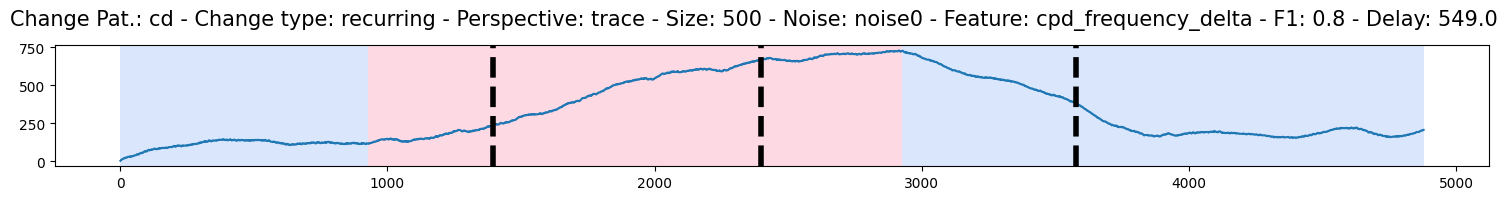

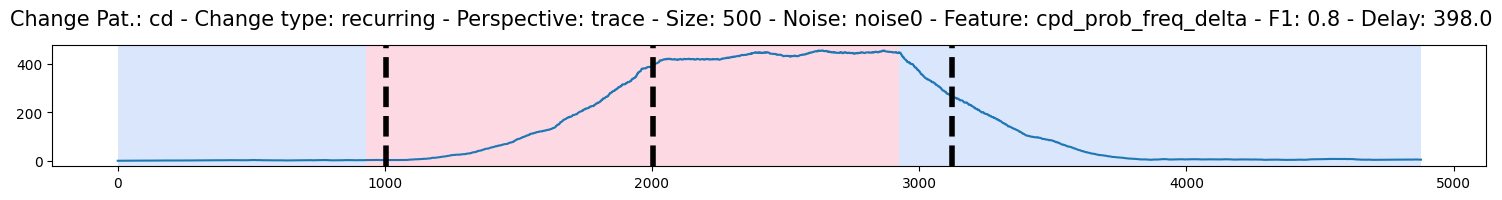

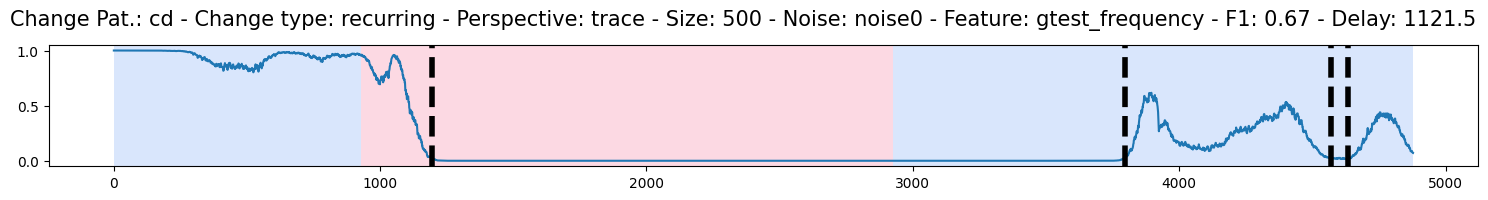

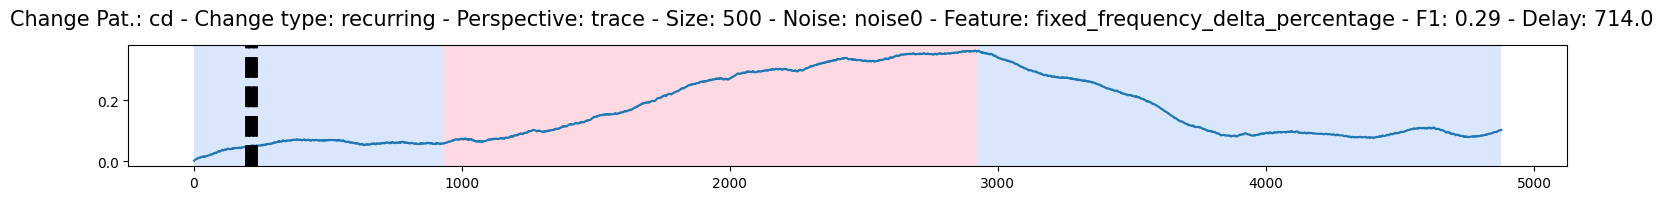

In [128]:
# Display Detection Task Results 
for result in detection_task_results.itertuples():
    fig, axarr = rpt.display(signal = TMPD_instance.get_change_representation()[TMPD_instance.detection_task_strategy_dict[result.detection_strategy][result.detection_feature]['change_features']]
                , true_chg_pts=ground_truth
                , computed_chg_pts = result.detection_results
                , computed_chg_pts_color = "k"
                , computed_chg_pts_linewidth = 4
                , computed_chg_pts_linestyle = "--"
                , computed_chg_pts_alpha = 1
                , figsize=(15, 2)
                )
    plt.suptitle("Change Pat.: " + log_path.split("/")[-1].split("_")[-1].split(".")[0]
                 + " - Change type: " + log_path.split("/")[-1].split("_")[-5].split("\\")[-1]
                 + " - Perspective: " + log_path.split("/")[-1].split("_")[-4]
                 + " - Size: " + log_path.split("/")[-1].split("_")[-2]
                 + " - Noise: " + log_path.split("/")[-1].split("_")[-3] 
                 + " - Feature: " + result.detection_feature
                 + " - F1: " + str(result.f1) 
                 + " - Delay: " + str(result.delay)
                 , fontsize=15)

    plt.subplots_adjust(top=0.8)
    plt.show()

## Step 6a - Setting Localization Task

In [129]:
# TODO

## Step 6b - Setting Characterization Task

In [130]:
# TODO

## Step 6c - Setting Explanation Task

In [131]:
# TODO